In [312]:
import cv2
import glob
import time
import locale
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.python import keras
from keras.models import Model
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import concatenate
from keras.layers.core import Dropout
from keras.callbacks import TensorBoard
from keras.models import model_from_yaml
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
#from keras.layers.normalization import BatchNormalization

In [313]:
#textfile_path = "C:\\Users\\HP\\Desktop\\Barcelona\\Term3\\DeepLearningApplication\\term_paper\\HousesDataset\\HousesInfo.txt"
textfile_path = "HousesDataset/HousesInfo.txt"

col = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

text_data = pd.read_csv(textfile_path, sep = ' ', names = col)

text_data.head(10)

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
5,4,5.0,4581,85266,1249000
6,3,4.0,2544,85262,799000
7,4,5.0,5524,85266,1698000
8,3,4.0,4229,85255,1749000
9,4,5.0,3550,85262,1500000


In [314]:
p_max = text_data['price'].max()

In [315]:
y = text_data['price']
text_data = text_data.drop(columns='price', axis=1)

X = text_data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=420)

In [316]:
def image_split(df):
    images = []

    for i in df.index.values:
        housePaths = sorted(list(glob.glob("HousesDataset/{}_*".format(i+1))))

        inputImages = []
        outputImage = np.zeros((256, 256, 3), dtype = "uint8")
                
        for housePath in housePaths : 
            image = cv2.imread(housePath)
            image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_CUBIC)
            inputImages.append(image)

            if len(inputImages) >= 4: 
                outputImage[0:128, 0:128] = inputImages[0]
                outputImage[0:128, 128:256] = inputImages[1]
                outputImage[128:256, 128:256] = inputImages[2]
                outputImage[128:256, 0:128] = inputImages[3]
            
                images.append(outputImage)

    return images


In [317]:
X_train_img = image_split(y_train)
X_test_img = image_split(y_test)

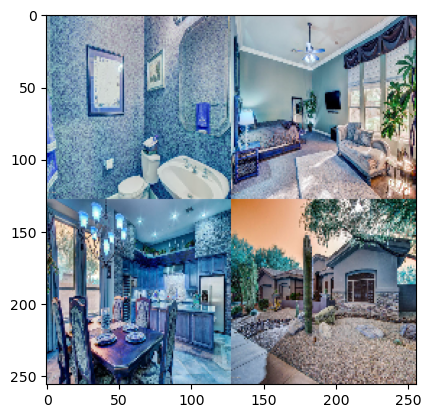

In [318]:
# visualise the data
plt.imshow(X_train_img[1])
plt.show()

In [319]:
# standarise images
X_train_img = np.multiply(X_train_img, (1/255))
X_test_img = np.multiply(X_test_img, (1/255))

# y is the price of the house corresponding to house i
y_train = np.stack(y_train)
y_train = y_train / p_max
y_test = np.stack(y_test)
y_test = y_test / p_max

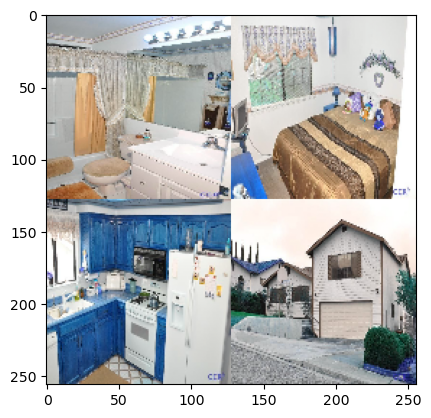

In [320]:
# visualisation pt. II
plt.imshow(X_test_img[3])
plt.show()

In [321]:
print(X_test_img[0])

[[[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.27843137 0.41568627 0.70196078]
  [0.27058824 0.41176471 0.68627451]
  [0.27058824 0.41568627 0.68235294]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.98823529 0.98823529 0.98823529]
  ...
  [0.24705882 0.38039216 0.65490196]
  [0.25490196 0.38823529 0.65490196]
  [0.25490196 0.39215686 0.64313725]]

 [[0.98823529 0.98823529 0.98823529]
  [0.98039216 0.98039216 0.98039216]
  [0.97647059 0.97647059 0.97647059]
  ...
  [0.25490196 0.38431373 0.64313725]
  [0.25098039 0.36862745 0.62745098]
  [0.20392157 0.3372549  0.57254902]]

 ...

 [[0.58039216 0.69803922 0.79607843]
  [0.63529412 0.75294118 0.85098039]
  [0.60392157 0.71372549 0.83137255]
  ...
  [0.61960784 0.7254902  0.84705882]
  [0.57647059 0.69019608 0.81568627]
  [0.65490196 0.78823529 0.90588235]]

 [[0.58039216 0.70196078 0.79215686]
  [0.63921569 0.75686275 0.85490196]


In [322]:
# check dimensions:
print(f'{X_train_img.shape} is the dimension of the training images')
print(f'{X_train.shape} is the dimension of the training data')
print(f'{y_train.shape} is the dimension of y train')

print(f'{X_test_img.shape} is the dimension of the testing images')
print(f'{X_test.shape} is the dimension of the testing data')
print(f'{y_test.shape} is the dimension of y test')

(481, 256, 256, 3) is the dimension of the training images
(481, 4) is the dimension of the training data
(481,) is the dimension of y train
(54, 256, 256, 3) is the dimension of the testing images
(54, 4) is the dimension of the testing data
(54,) is the dimension of y test


In [323]:
print(X_train.isna().sum())
print(X_test.isna().sum())

bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64
bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64


In [324]:
def standardise_df(df, df_test):

    scaler = MinMaxScaler()

    df_standardized = scaler.fit_transform(df)
    df_standardized_test = scaler.transform(df_test)

    return df_standardized, df_standardized_test

In [325]:
X_train, X_test = standardise_df(X_train, X_test)

In [326]:
# neural network for tabular data

def tabular_nn():
    nn = Sequential()
    nn.add(Dropout(0.2, input_shape=(4,)))
    nn.add(Dense(16, activation='relu'))
    nn.add(Dense(4, activation='relu'))
    return nn

In [327]:
# convolutional neural network for images
def cnn():

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='relu'))

    return model

In [328]:
tabular_model = tabular_nn()
cnn_model = cnn()

merged = concatenate([tabular_model.output, cnn_model.output])

final_dense = Dense(4, activation='relu')(merged)
output = Dense(1)(final_dense)

model = Model(inputs=[tabular_model.input, cnn_model.input], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [329]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
history = model.fit([X_train, X_train_img], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30


2023-06-07 16:21:28.840852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.6542

2023-06-07 16:21:31.608992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 4s 192ms/step - loss: 1.6542 - val_loss: 0.0443
Epoch 2/30
14/14 [==============================] - 3s 186ms/step - loss: 0.0213 - val_loss: 0.0107
Epoch 3/30
14/14 [==============================] - 2s 161ms/step - loss: 0.0147 - val_loss: 0.0085
Epoch 4/30
14/14 [==============================] - 2s 152ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 5/30
14/14 [==============================] - 2s 156ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 6/30
14/14 [==============================] - 2s 156ms/step - loss: 0.0083 - val_loss: 0.0056
Epoch 7/30
14/14 [==============================] - 2s 165ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 8/30
14/14 [==============================] - 3s 196ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 9/30
14/14 [==============================] - 3s 183ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 10/30
14/14 [==============================] - 2s 179ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 11/3

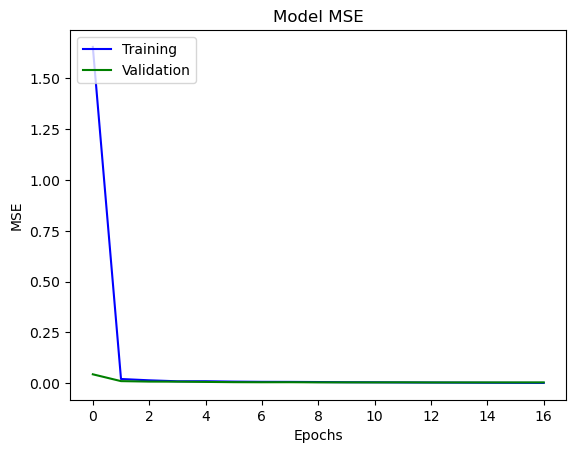

In [330]:
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [331]:
predictions = model.predict([X_test, X_test_img])

2023-06-07 16:22:15.571869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 139ms/step


In [332]:
# MSE
error = predictions.flatten() - y_test
squared_error = error ** 2
MSE = np.mean(squared_error)
print(MSE)

0.0037162145793668217
